<div align="center"><h1> Projet Data Science </h1></div>
<div align="center"><h2> Classification d'assertions selon leur valeurs de véracité ( automatic fact-checking ) </h2></div>

<div class="alert alert-block alert-info" align="center">
    <h1>
        Imports
    </h1>
</div>

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import warnings
import nltk
import pickle
import unicodedata
import inflect
import re
import time

from enum import Enum
from functools import reduce
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

warnings.filterwarnings("ignore", category = FutureWarning)

<div class="alert alert-block alert-info" align="center">
    <h1>
        Downloads
    </h1>
</div>

In [2]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
    
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

<div class="alert alert-block alert-info" align="center">
    <h1>
        Declarations
    </h1>
</div>

In [3]:
# Mapping ratings
class NormalizedRatings(Enum):
    FALSE = 1
    MIXTURE = 2
    TRUE = 3
    OTHER = -1

_normalization_dictionary = {  # type: Dict[str, Dict[str,NormalizedRatings]]
    "politifact": {  # type: Dict[str,NormalizedRatings]
        'incorrect': NormalizedRatings.FALSE,
        'pants-fire': NormalizedRatings.FALSE,
        'pants on fire': NormalizedRatings.FALSE,
        'pants on fire!': NormalizedRatings.FALSE,
        'false': NormalizedRatings.FALSE,
        'mostly correct': NormalizedRatings.MIXTURE,
        'mostly false': NormalizedRatings.MIXTURE,
        'barely true': NormalizedRatings.MIXTURE,
        'half true': NormalizedRatings.MIXTURE,
        'half-true': NormalizedRatings.MIXTURE,
        'mostly true': NormalizedRatings.MIXTURE,
        'true': NormalizedRatings.TRUE,
        'correct': NormalizedRatings.TRUE
    },
    "snopes": {  # type: Dict[str,NormalizedRatings]
        'false': NormalizedRatings.FALSE,
        'legend': NormalizedRatings.FALSE,
        'mixture': NormalizedRatings.MIXTURE,
        'mixture:': NormalizedRatings.MIXTURE,
        'true': NormalizedRatings.TRUE,
        'mostly false': NormalizedRatings.MIXTURE,
        'mostly true': NormalizedRatings.MIXTURE,
        'partly true': NormalizedRatings.MIXTURE,
        'MIXTURE OF TRUE AND FALSE INFORMATION': NormalizedRatings.MIXTURE,
        'MIXTURE OF TRUE AND FALSE INFORMATION:': NormalizedRatings.MIXTURE,
        'MIXTURE OF ACCURATE AND  INACCURATE INFORMATION': NormalizedRatings.MIXTURE
    },
    "africacheck": {  # type: Dict[str,NormalizedRatings]
        'incorrect': NormalizedRatings.FALSE,
        'mostly-correct': NormalizedRatings.MIXTURE,
        'correct': NormalizedRatings.TRUE
    },
    "factscan": {  # type: Dict[str,NormalizedRatings]
        'false': NormalizedRatings.FALSE,
        'true': NormalizedRatings.TRUE,
        'Misleading': NormalizedRatings.OTHER
    },
    "truthorfiction": {  # type: Dict[str,NormalizedRatings]
        'fiction': NormalizedRatings.FALSE,
        'truth': NormalizedRatings.TRUE,
        'truth & fiction': NormalizedRatings.MIXTURE,
        'mostly fiction': NormalizedRatings.MIXTURE,
        'truth & misleading': NormalizedRatings.MIXTURE,
        'mostly truth': NormalizedRatings.MIXTURE
    },
    "checkyourfact": {  # type: Dict[str,NormalizedRatings]
        'False': NormalizedRatings.FALSE,
        'True': NormalizedRatings.TRUE,
        'Mostly True': NormalizedRatings.MIXTURE,
        'true/false': NormalizedRatings.MIXTURE,
        'truth & misleading': NormalizedRatings.MIXTURE,
        'mostly truth': NormalizedRatings.MIXTURE,
        'misleading': NormalizedRatings.MIXTURE
    },
    "factcheck_aap": {
        "True": NormalizedRatings.TRUE,
        "False": NormalizedRatings.FALSE,
        "Mostly True": NormalizedRatings.MIXTURE,
        "Mostly False": NormalizedRatings.MIXTURE,
        "Somewhat True": NormalizedRatings.MIXTURE,
        "Somewhat False": NormalizedRatings.MIXTURE
    },
    "factuel_afp_fr": {
        'Faux': NormalizedRatings.FALSE,
        'Totalement faux': NormalizedRatings.FALSE,
        'Démenti': NormalizedRatings.FALSE,
        "C'est une oeuvre de fiction": NormalizedRatings.FALSE,
        'Vrai': NormalizedRatings.TRUE,
        'Totalement Vrai': NormalizedRatings.TRUE,
        'Plutôt vrai': NormalizedRatings.MIXTURE,
        'Trompeur': NormalizedRatings.MIXTURE,
        'trompeur': NormalizedRatings.MIXTURE,
        'Plutôt faux': NormalizedRatings.MIXTURE,
        'Presque': NormalizedRatings.MIXTURE,
        'Mélangé': NormalizedRatings.MIXTURE,
        'Mélange': NormalizedRatings.MIXTURE,
        'Inexact': NormalizedRatings.MIXTURE,
        'Incertain': NormalizedRatings.MIXTURE,
        'Imprécis': NormalizedRatings.MIXTURE,
        'Exagéré': NormalizedRatings.MIXTURE,
        'Douteux': NormalizedRatings.MIXTURE,
    },
    "factcheck_afp": {
        'False': NormalizedRatings.FALSE,
        'Fake': NormalizedRatings.FALSE,
        'Mixed': NormalizedRatings.MIXTURE,
        'Hoax': NormalizedRatings.FALSE,
        'Falso': NormalizedRatings.FALSE,
        'APRIL FOOL': NormalizedRatings.FALSE
    },
    "fullfact": {
        'Correct': NormalizedRatings.TRUE,
        'Incorrect': NormalizedRatings.FALSE,
        'Not quite': NormalizedRatings.MIXTURE
    }
}

def _standardize_name(original_name: str):
    return original_name.strip().lower().replace("!", "").replace(":", "").replace("-", " ")

def normalize(source_name, original_name) -> NormalizedRatings:
    '''
    Generate a normalized rating from the original ratings on each respective site
    :param original_name:
    :return normalized_rating: NormalizedRating
    '''
    try:
        source = _normalization_dictionary[source_name]
        normalized_value = source[_standardize_name(original_name)]
    except KeyError:
        normalized_value = NormalizedRatings.OTHER
    return normalized_value

# Cleaning the text
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word) 
    return new_words

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def separate_letter_number(words):
    new_words = []
    for word in words:
        nw = re.findall('\d+|\D+', word)
        new_words.append(nw)
    new_words = reduce(lambda x,y: x+y,new_words)
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    #words = separate_letter_number(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

def clean_text(text):
    tokens = word_tokenize(text)
    tokens = normalize(tokens)
    text="".join([" "+i for i in tokens]).strip()
    return text

# Reding data
def read_data(*args, **kwargs):
    data = kwargs.get("data", 'test')
    number = kwargs.get("number", 1000)
    labels = ["ID", "Text", "Date", "TruthRating", "RatingName", "Author", "Headline", 
              "NamedEntitiesClaim", "NamedEntitiesArticle", "Keywords", "Source", "SourceURL", "Link", "Language"]
    
    if(data not in ['all', 'polsno', 'test']):
        print('Please selecte somthing in [\'all\', \'polsno\', \'test\']')
    else:
        df_func = pd.read_csv('datasets/test.csv', sep = ',', names = labels, skiprows = 1, nrows = number)
        pol1 = pd.read_csv('datasets/pol1.csv', sep = ',', names = labels, skiprows = 1)
        pol2 = pd.read_csv('datasets/pol2.csv', sep = ',', names = labels, skiprows = 1)
        sno1 = pd.read_csv('datasets/sno1.csv', sep = ',', names = labels, skiprows = 1)
        sno2 = pd.read_csv('datasets/sno2.csv', sep = ',', names = labels, skiprows = 1)
        reste = pd.read_csv('datasets/reste.csv', sep = ',', names = labels, skiprows = 1)

        pol = pol1.append(pol2, sort = False).reset_index(drop = True)
        sno = sno1.append(sno2, sort = False).reset_index(drop = True)
        polsno = pol.append(sno, sort = False).reset_index(drop = True)
        everything = polsno.append(reste, sort = False).reset_index(drop = True)
        
        if(df_func.shape[0] != number):
            print(f'Not enough data !\nReading only {df_func.shape[0]} claims')
            number = df_func.shape[0]
        if(df_func.shape[0] == number):
            print(f'Reading successfully {number} claims')

        if(data == 'polsno'):
            df_func = polsno.sample(n = number).reset_index(drop = True)
        if(data == 'all'):
            df_func = everything.sample(n = number).reset_index(drop = True)
        
        for column in df_func.columns:
            df_func[column].replace(to_replace = True, value = 'TRUE', inplace = True)
            df_func[column].replace(to_replace = False, value = 'FALSE', inplace = True)

        return df_func

# Up-sampling & Down-sampling
def sampling(df_func, *args, **kwargs):
    sampling_type = kwargs.get("sample", None)
    if(sampling_type not in ['up', 'down']):
        print('Please select somthing in [\'up\', \'down\']')

    else:
        majority = df_func[df_func.RatingName == df_func['RatingName'].value_counts().index.tolist()[0]].reset_index(drop = True)
        minority = df_func[df_func.RatingName == df_func['RatingName'].value_counts().index.tolist()[-1]].reset_index(drop = True)

        if(sampling_type == 'up'):
            df_func = resample(minority, replace = True, n_samples = df['RatingName'].value_counts().tolist()[0], random_state = 123)
            df_func = pd.concat([majority, df_func]).sample(frac = 1).reset_index(drop = True)

        if(sampling_type == 'down'):
            df_func = resample(majority, replace=False, n_samples=df['RatingName'].value_counts().tolist()[-1], random_state=123) 
            df_func = pd.concat([df_func, minority]).reset_index(drop = True)

        return df_func

# Compte rendu de classification
def cpt_mal_classes(y_test_func, result_func):
    nb_func = 0
    for i in range(len(y_test_func)):
        if y_test_func[i] != result_func[i]:
            nb_func += 1
    print (f'Taille des données {len(y_test_func)} mal classés {nb_func}\n')

<div class="alert alert-block alert-info" align="center">
    <h1>
        Reading data & Printing informations
    </h1>
</div>

<div align="center">
    <h1>Reading data</h1>
</div>
<h2>read_data(data='test', number = '1000')</h2>
<ul>
    <li><b>data</b></li>
	<ul>
		<li>'all' for all website</li>
		<li>'polsno' for politifact's and snopes' claims </li>
		<li>'test' for csv test (all sites) with 10000 claims max</li>
	</ul>
        <li><b>number</b></li>
	<ul>
		<li>number of claims to generate</li>
	</ul>
</ul>

In [4]:
df = read_data(data = 'test', number = 500)

Reading successfully 500 claims


## Shape

In [5]:
print(f'Shape :\n{df.shape}')

Shape :
(500, 14)


## Informations

In [6]:
print(f'Informations :')
df.info()

Informations :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
ID                      500 non-null object
Text                    500 non-null object
Date                    500 non-null object
TruthRating             500 non-null object
RatingName              500 non-null object
Author                  500 non-null object
Headline                496 non-null object
NamedEntitiesClaim      495 non-null object
NamedEntitiesArticle    321 non-null object
Keywords                442 non-null object
Source                  500 non-null object
SourceURL               500 non-null object
Link                    500 non-null object
Language                500 non-null object
dtypes: object(14)
memory usage: 54.8+ KB


## Description

In [7]:
print(f'Description :')
display(df.describe())

Description :


,ID,Text,Date,TruthRating,RatingName,Author,Headline,NamedEntitiesClaim,NamedEntitiesArticle,Keywords,Source,SourceURL,Link,Language
count,500,500,500,500,500,500,496,495,321,442,500,500,500,500
unique,500,500,258,4,4,197,496,495,296,353,9,9,500,1
top,http://data.gesis.org/claimskg/claim_review/6a...,The church Barack Obama belongs to only admits...,Unknown,TRUE,FALSE,Unknown,Ted Cruz: Vets Should Sell Cookies for Funding...,"Hispanic,Kaiser Family Foundation,Kanye West,M...",Donald Trump,ASP Article,politifact,http://www.politifact.com,http://www.politifact.com/wisconsin/statements...,English
freq,1,1,235,184,184,235,1,1,7,21,255,255,1,500


## Printing some lines

In [8]:
print(f'Printing some lines :')
display(df.head())

Printing some lines :


,ID,Text,Date,TruthRating,RatingName,Author,Headline,NamedEntitiesClaim,NamedEntitiesArticle,Keywords,Source,SourceURL,Link,Language
0,http://data.gesis.org/claimskg/claim_review/be...,Malia Obama cashed a $1.2 million tax refund c...,Unknown,-1,OTHER,Unknown,Did Malia Obama Cash a $1.2 Million Check?,"Facebook,Fan Fiction,Junk News,Malia Obama,Sno...",Malia Obama,NaN,truthorfiction,https://www.truthorfiction.com,https://www.truthorfiction.com/did-malia-obama...,English
1,http://data.gesis.org/claimskg/claim_review/8a...,High diver is saved from jumping into a draine...,Unknown,-1,OTHER,Unknown,High Diver Saved By Cross,"Cincinnati Post,Islam,Scripture lesson,Univers...",shadow on the wall,ASP Article,snopes,http://www.snopes.com,https://www.snopes.com/fact-check/high-and-mig...,English
2,http://data.gesis.org/claimskg/claim_review/c2...,'And the revenue generated by drilling off Vir...,2012-02-15,2,MIXTURE,Jim Moran,Moran says drilling off Virginia's coast will ...,"Alaska,American Petroleum Institute,Atlantic O...",NaN,"Energy,State Finances",politifact,http://www.politifact.com,http://www.politifact.com/virginia/statements/...,English
3,http://data.gesis.org/claimskg/claim_review/1e...,Health insurance companies pay CEOs $24 millio...,2009-09-15,2,MIXTURE,Health Care for America Now,Health care advocacy group blasts insurers for...,"Aetna,Assurant,Bloomberg News,Cigna,Coventry H...",NaN,"Corporations,Health Care",politifact,http://www.politifact.com,http://www.politifact.com/truth-o-meter/statem...,English
4,http://data.gesis.org/claimskg/claim_review/0b...,Ted Cruz said that veterans should start selli...,Unknown,TRUE,FALSE,Unknown,Ted Cruz: Vets Should Sell Cookies for Funding...,"David Nelson,James Morrison,John Scalzi,Republ...",Ted Cruz,"ASP Article, Not Necessarily The News",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/cruz-cookies/,English


## Affichage d'informations sur toutes les colonnes

In [9]:
for column in df.columns:
      print(f'Nombre de valeurs nulles pour {column} :\n{df[column].isnull().value_counts()}\n')

Nombre de valeurs nulles pour ID :
False    500
Name: ID, dtype: int64

Nombre de valeurs nulles pour Text :
False    500
Name: Text, dtype: int64

Nombre de valeurs nulles pour Date :
False    500
Name: Date, dtype: int64

Nombre de valeurs nulles pour TruthRating :
False    500
Name: TruthRating, dtype: int64

Nombre de valeurs nulles pour RatingName :
False    500
Name: RatingName, dtype: int64

Nombre de valeurs nulles pour Author :
False    500
Name: Author, dtype: int64

Nombre de valeurs nulles pour Headline :
False    496
True       4
Name: Headline, dtype: int64

Nombre de valeurs nulles pour NamedEntitiesClaim :
False    495
True       5
Name: NamedEntitiesClaim, dtype: int64

Nombre de valeurs nulles pour NamedEntitiesArticle :
False    321
True     179
Name: NamedEntitiesArticle, dtype: int64

Nombre de valeurs nulles pour Keywords :
False    442
True      58
Name: Keywords, dtype: int64

Nombre de valeurs nulles pour Source :
False    500
Name: Source, dtype: int64

Nombre

## Affichage des colonnes vides

In [10]:
array = []
for column in df.columns:
    value = False
    value = df[column].isnull().any()
    if value:
        array.append(column)
print(f'Nombre de colonnes vides : {len(array)}\nLes colonnes vide sont :\n{array}')

Nombre de colonnes vides : 4
Les colonnes vide sont :
['Headline', 'NamedEntitiesClaim', 'NamedEntitiesArticle', 'Keywords']


## Description de toutes les colonnes

In [11]:
for column in df.columns:
    display(df[column].describe())

count                                                   500
unique                                                  500
top       http://data.gesis.org/claimskg/claim_review/6a...
freq                                                      1
Name: ID, dtype: object

count                                                   500
unique                                                  500
top       The church Barack Obama belongs to only admits...
freq                                                      1
Name: Text, dtype: object

count         500
unique        258
top       Unknown
freq          235
Name: Date, dtype: object

count      500
unique       4
top       TRUE
freq       184
Name: TruthRating, dtype: object

count       500
unique        4
top       FALSE
freq        184
Name: RatingName, dtype: object

count         500
unique        197
top       Unknown
freq          235
Name: Author, dtype: object

count                                                   496
unique                                                  496
top       Ted Cruz: Vets Should Sell Cookies for Funding...
freq                                                      1
Name: Headline, dtype: object

count                                                   495
unique                                                  495
top       Hispanic,Kaiser Family Foundation,Kanye West,M...
freq                                                      1
Name: NamedEntitiesClaim, dtype: object

count              321
unique             296
top       Donald Trump
freq                 7
Name: NamedEntitiesArticle, dtype: object

count             442
unique            353
top       ASP Article
freq               21
Name: Keywords, dtype: object

count            500
unique             9
top       politifact
freq             255
Name: Source, dtype: object

count                           500
unique                            9
top       http://www.politifact.com
freq                            255
Name: SourceURL, dtype: object

count                                                   500
unique                                                  500
top       http://www.politifact.com/wisconsin/statements...
freq                                                      1
Name: Link, dtype: object

count         500
unique          1
top       English
freq          500
Name: Language, dtype: object

## Get a series of unique values in each column of the dataframe

In [12]:
for column in df.columns:
    uniqueValues = df[column].unique()
    print(f'Number of unique elements in column {column} : {len(uniqueValues)}, values & type :\n{uniqueValues}\n')

Number of unique elements in column ID : 500, values & type :
['http://data.gesis.org/claimskg/claim_review/becd1657-d104-5a3e-94de-61f26b8e3f6e'
 'http://data.gesis.org/claimskg/claim_review/8a8a0f17-b1ec-5f86-8ad4-4bb0f1dd5cf5'
 'http://data.gesis.org/claimskg/claim_review/c215a999-c7cf-5c9f-bada-bcddfccd9a56'
 'http://data.gesis.org/claimskg/claim_review/1eff01a2-4c7d-5a9c-928a-1fa9a888ddeb'
 'http://data.gesis.org/claimskg/claim_review/0b7ea833-4928-5405-b0e0-12b2b31482b6'
 'http://data.gesis.org/claimskg/claim_review/a18e6db1-5ab3-5cbd-b913-155ba758039d'
 'http://data.gesis.org/claimskg/claim_review/b46c9e5a-3d3e-5292-aec5-65e9aa4c1f16'
 'http://data.gesis.org/claimskg/claim_review/b1f0ccba-1f2f-5e3f-b2a3-827a4f21dc1d'
 'http://data.gesis.org/claimskg/claim_review/78b5ce3e-a8db-52a2-8c4e-5e1a71d651d3'
 'http://data.gesis.org/claimskg/claim_review/9c52e9fc-3231-52b6-944c-94ca5f80abd5'
 'http://data.gesis.org/claimskg/claim_review/ad4543c1-9a8b-59b6-b68f-0c5f2a8ab3ee'
 'http://data.


Number of unique elements in column Text : 500, values & type :
['Malia Obama cashed a $1.2 million tax refund check.'
 'High diver is saved from jumping into a drained pool when he casts a cross-like shadow on the wall.'
 "'And the revenue generated by drilling off Virginia’s coast? $40 million over 10 years.'"
 'Health insurance companies pay CEOs $24 million a year'
 'Ted Cruz said that veterans should start selling cookies in order to raise funds.'
 "Passengers on an airliner diverted to Cuba thought the hijacking was a Candid Camera stunt due to the coincidental presence of the show's host, Allen Funt."
 "Oil money from federal leases 'can only be used to clean up the mess and damages from drilling.'"
 "'The Georgia Lottery Corp. has only once in the past 16 years paid out the agreed upon 35 percent of proceeds to the account which funds the HOPE scholarship.'"
 "'When Mitt Romney was governor, Massachusetts lost 40,000 manufacturing jobs, a rate twice the national average.'"
 'P


Number of unique elements in column Source : 9, values & type :
['truthorfiction' 'snopes' 'politifact' 'fullfact' 'checkyourfact'
 'factcheck_afp' 'africacheck' 'factscan' 'factuel_afp_fr']

Number of unique elements in column SourceURL : 9, values & type :
['https://www.truthorfiction.com' 'http://www.snopes.com'
 'http://www.politifact.com' 'https://fullfact.org/'
 'http://checkyourfact.com' 'https://factcheck.afp.com/'
 'https://africacheck.org' 'http://factscan.ca' 'https://factuel.afp.com/']

Number of unique elements in column Link : 500, values & type :
['https://www.truthorfiction.com/did-malia-obama-cash-a-1-2-million-check/'
 'https://www.snopes.com/fact-check/high-and-might-y/'
 'http://www.politifact.com/virginia/statements/2012/mar/23/jim-moran/moran-says-dilling-virginias-coast-will-net-4-mill/'
 'http://www.politifact.com/truth-o-meter/statements/2009/sep/16/health-care-america-now/health-care-advocacy-group-blasts-insurers-ceo-pay/'
 'https://www.snopes.com/fact-check

## Affichage du nombre des différents TruthRating

In [13]:
print(f'La colonne TruthRating contient :')
print(f'{df[df["TruthRating"]==-1]["ID"].count()} Other')
print(f'{df[df["TruthRating"]==1]["ID"].count()} False')
print(f'{df[df["TruthRating"]==2]["ID"].count()} Mixture')
print(f'{df[df["TruthRating"]==3]["ID"].count()} True')

La colonne TruthRating contient :
77 Other
0 False
174 Mixture
65 True


<div class="alert alert-block alert-info" align="center">
    <h1>
        Visualization
    </h1>
</div>

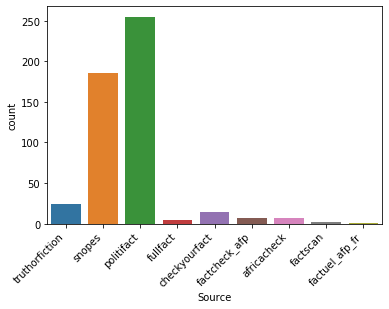

In [14]:
chart = sns.countplot(x = 'Source', data = df)
plt.setp(chart.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

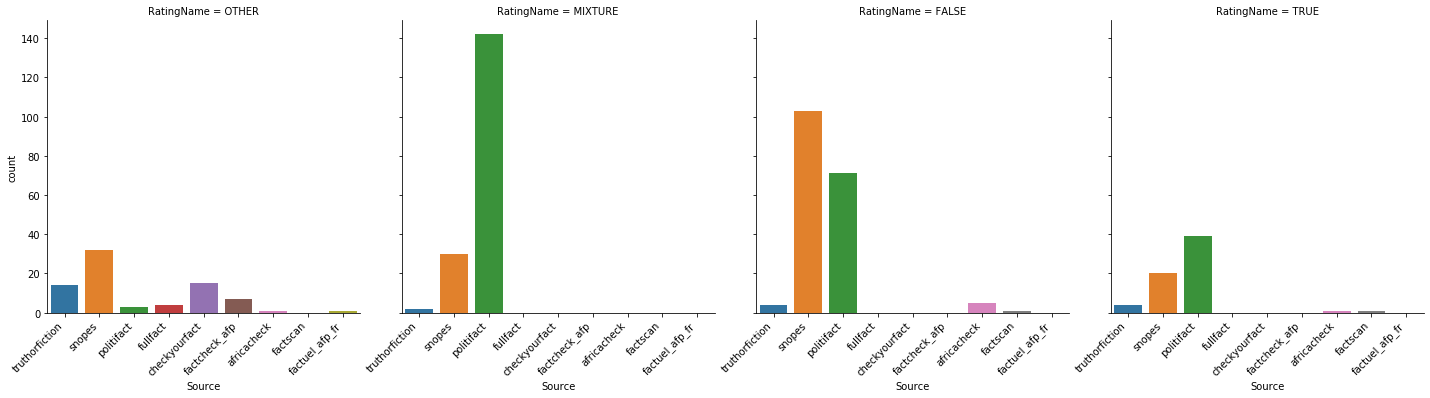

In [15]:
chart = sns.catplot(x = 'Source', col = 'RatingName', kind = 'count', data = df)
for ax in chart.axes.ravel():
    plt.setp(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

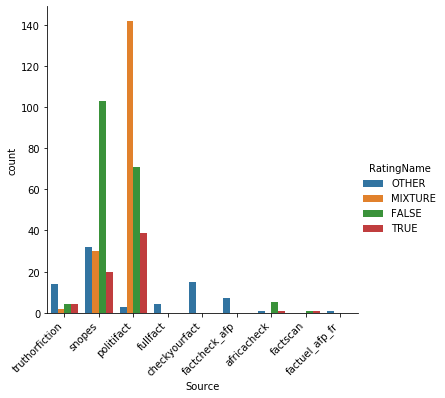

In [16]:
chart = sns.catplot('Source', data = df, hue = 'RatingName', kind = 'count')
for ax in chart.axes.ravel():
    plt.setp(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

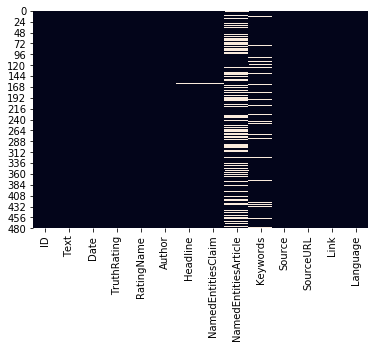

In [17]:
sns.heatmap(df.isnull(), cbar = False)
plt.show()

<div class="alert alert-block alert-info" align="center">
    <h1>
        Pre-processing
    </h1>
</div>

<div align="center">
    <h1>
        General pre-processing
    </h1>
</div>

## Remove unnecessary columns

In [18]:
df = df.drop(['ID', 'Date', 'TruthRating', 'SourceURL', 'Link', 'Language'], axis = 1)
display(df.head())

,Text,RatingName,Author,Headline,NamedEntitiesClaim,NamedEntitiesArticle,Keywords,Source
0,Malia Obama cashed a $1.2 million tax refund c...,OTHER,Unknown,Did Malia Obama Cash a $1.2 Million Check?,"Facebook,Fan Fiction,Junk News,Malia Obama,Sno...",Malia Obama,NaN,truthorfiction
1,High diver is saved from jumping into a draine...,OTHER,Unknown,High Diver Saved By Cross,"Cincinnati Post,Islam,Scripture lesson,Univers...",shadow on the wall,ASP Article,snopes
2,'And the revenue generated by drilling off Vir...,MIXTURE,Jim Moran,Moran says drilling off Virginia's coast will ...,"Alaska,American Petroleum Institute,Atlantic O...",NaN,"Energy,State Finances",politifact
3,Health insurance companies pay CEOs $24 millio...,MIXTURE,Health Care for America Now,Health care advocacy group blasts insurers for...,"Aetna,Assurant,Bloomberg News,Cigna,Coventry H...",NaN,"Corporations,Health Care",politifact
4,Ted Cruz said that veterans should start selli...,FALSE,Unknown,Ted Cruz: Vets Should Sell Cookies for Funding...,"David Nelson,James Morrison,John Scalzi,Republ...",Ted Cruz,"ASP Article, Not Necessarily The News",snopes


## Remove unnecessary rows

In [19]:
# Deleting claims with OTHER RatingName
df = df[df.RatingName != 'OTHER']

display(df.head())

,Text,RatingName,Author,Headline,NamedEntitiesClaim,NamedEntitiesArticle,Keywords,Source
2,'And the revenue generated by drilling off Vir...,MIXTURE,Jim Moran,Moran says drilling off Virginia's coast will ...,"Alaska,American Petroleum Institute,Atlantic O...",NaN,"Energy,State Finances",politifact
3,Health insurance companies pay CEOs $24 millio...,MIXTURE,Health Care for America Now,Health care advocacy group blasts insurers for...,"Aetna,Assurant,Bloomberg News,Cigna,Coventry H...",NaN,"Corporations,Health Care",politifact
4,Ted Cruz said that veterans should start selli...,FALSE,Unknown,Ted Cruz: Vets Should Sell Cookies for Funding...,"David Nelson,James Morrison,John Scalzi,Republ...",Ted Cruz,"ASP Article, Not Necessarily The News",snopes
5,Passengers on an airliner diverted to Cuba tho...,MIXTURE,Unknown,Did Airline Passengers Mistake a Hijacking for...,"Allen Funt,Associated Press,CBS,Candid Camera,...","Allen Funt,Candid Camera,Cuba","Broadcast Legends, Radio & TV, Television",snopes
6,Oil money from federal leases 'can only be use...,MIXTURE,Bill Nelson,Sen. Bill Nelson says offshore drilling won't ...,"Alabama,Bill Nelson,D-Fla,Florida Panhandle,Gu...",NaN,Environment,politifact


## Replacing "Unknown" & NaN by "Inconnue"

In [20]:
for column in df.columns:
    df[column].replace(to_replace = 'Unknown', value = 'Inconnue', inplace = True)
    df[column].replace(np.NaN, 'Inconnue', inplace = True)
    
display(df.head())

,Text,RatingName,Author,Headline,NamedEntitiesClaim,NamedEntitiesArticle,Keywords,Source
2,'And the revenue generated by drilling off Vir...,MIXTURE,Jim Moran,Moran says drilling off Virginia's coast will ...,"Alaska,American Petroleum Institute,Atlantic O...",Inconnue,"Energy,State Finances",politifact
3,Health insurance companies pay CEOs $24 millio...,MIXTURE,Health Care for America Now,Health care advocacy group blasts insurers for...,"Aetna,Assurant,Bloomberg News,Cigna,Coventry H...",Inconnue,"Corporations,Health Care",politifact
4,Ted Cruz said that veterans should start selli...,FALSE,Inconnue,Ted Cruz: Vets Should Sell Cookies for Funding...,"David Nelson,James Morrison,John Scalzi,Republ...",Ted Cruz,"ASP Article, Not Necessarily The News",snopes
5,Passengers on an airliner diverted to Cuba tho...,MIXTURE,Inconnue,Did Airline Passengers Mistake a Hijacking for...,"Allen Funt,Associated Press,CBS,Candid Camera,...","Allen Funt,Candid Camera,Cuba","Broadcast Legends, Radio & TV, Television",snopes
6,Oil money from federal leases 'can only be use...,MIXTURE,Bill Nelson,Sen. Bill Nelson says offshore drilling won't ...,"Alabama,Bill Nelson,D-Fla,Florida Panhandle,Gu...",Inconnue,Environment,politifact


## Text cleaning

In [21]:
for column in df.columns:
    df[column] = df[column].apply(lambda x: clean_text(x))

display(df)
display(df.describe())

,Text,RatingName,Author,Headline,NamedEntitiesClaim,NamedEntitiesArticle,Keywords,Source
2,revenue generated drilling virginia coast fort...,mixture,jim moran,moran says drilling virginia coast net forty m...,alaska american petroleum institute atlantic o...,inconnue,energy state finances,politifact
3,health insurance companies pay ceos twentyfour...,mixture,health care america,health care advocacy group blasts insurers ceo...,aetna assurant bloomberg news cigna coventry h...,inconnue,corporations health care,politifact
4,ted cruz said veterans start selling cookies o...,false,inconnue,ted cruz vets sell cookies funding like girl s...,david nelson james morrison john scalzi republ...,ted cruz,asp article necessarily news,snopes
5,passengers airliner diverted cuba thought hija...,mixture,inconnue,airline passengers mistake hijacking candid ca...,allen funt associated press cbs candid camera ...,allen funt candid camera cuba,broadcast legends radio tv television,snopes
6,oil money federal leases used clean mess damag...,mixture,bill nelson,sen bill nelson says offshore drilling wo nt p...,alabama bill nelson dfla florida panhandle gul...,inconnue,environment,politifact
...,...,...,...,...,...,...,...,...
493,spoken directly whistleblower,false,adam schiff,adam schiff false claim spoken directly whistl...,adam schiff anderson cooper cnn daily beast do...,whistleblower,congressional rules impeachment,politifact
494,says attorney general candidate jon richards w...,false,brad schimel,democratic candidate attorney general would de...,associated press barack obama brad schimel dan...,inconnue,elections ethics gays lesbians guns legal issu...,politifact
495,three women per day lose lives hands partners,true,james brown,cbs sports james brown three women per day kil...,baltimore ravens bureau justice statistics cbs...,inconnue,crime criminal justice women,politifact
498,bill cap carbon emissions could cost ohio 1000...,mixture,rob portman,portman uses outdated context claim capandtrad...,american enterprise institute barack obama bro...,inconnue,cap trade climate change economy energy,politifact


,Text,RatingName,Author,Headline,NamedEntitiesClaim,NamedEntitiesArticle,Keywords,Source
count,423,423,423,423,423,423,423,423
unique,423,3,192,423,423,245,326,5
top,3000 teachers lost jobs crist governor,false,inconnue,conservative website wrongly ties clinton foun...,mount pinatubo mt pinatubo philippines phillip...,inconnue,inconnue,politifact
freq,1,184,169,1,1,157,20,252


## To do the treatments

In [22]:
classLabelEncoder = LabelEncoder()

tfidfVectorizer = TfidfVectorizer()

tfidfTransformer1 = TfidfTransformer()
tfidfTransformer2 = TfidfTransformer(use_idf = False)

countVectorizer = CountVectorizer()

standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()

# How to use
#df = pd.DataFrame(standardScaler.fit_transform(df), columns = ['Name'])

<div align="center">
    <h1>
        TRUE vs FALSE
    </h1>
</div>

In [23]:
dfTvsF = df.copy()

# Suppression de MIXTURE
dfTvsF = dfTvsF[dfTvsF.RatingName != 'mixture']

dfTvsF = sampling(dfTvsF, sample = 'up')
display(dfTvsF)

# Splitting the datafram
dfTvsFHeadlineText = dfTvsF["Headline"] + " " + dfTvsF["Text"]
dfTvsFRatingName = dfTvsF['RatingName']
dfTvsFAuthor = dfTvsF['Author']
dfTvsFNamedEntitiesClaim = dfTvsF['NamedEntitiesClaim']
dfTvsFNamedEntitiesArticle = dfTvsF['NamedEntitiesArticle']
dfTvsFKeywords = dfTvsF['Keywords']
dfTvsFSource = dfTvsF['Source']

,Text,RatingName,Author,Headline,NamedEntitiesClaim,NamedEntitiesArticle,Keywords,Source
0,says 94 percent marco rubio constituents suppo...,true,mark kelly,mark kelly says ninetyfour percent floridians ...,americans responsible solutions chris wallace ...,marco rubio universal background check,guns,politifact
1,republican gotten endorsements presidential ra...,true,mike huckabee,unions gave huck gop nod,aflcio center responsive politics hillary clin...,republican,elections,politifact
2,obama visited countries met world leaders pres...,true,chain email,chain email claims obama visited countries fir...,barack obama bill clinton brendan doherty cbs ...,inconnue,foreign policy,politifact
3,hillary clinton used green screen add fake aud...,false,inconnue,hillary clinton used green screen make fake cr...,barry soetoro hillary clinton youtube green sc...,hillary clinton,clinton clinton green screen green screen hill...,snopes
4,warren buffett still support,true,barack obama,billionaire warren buffett still backs obama,berkshire hathaway bill gates cnbc steve kroft...,inconnue,economy,politifact
...,...,...,...,...,...,...,...,...
363,sold state airplanes promised,true,rick scott,gov rick scott says sold state planes,cessna citation bravo jd alexander rick scott ...,inconnue,state budget,politifact
364,approximately fortythree percent college grade...,true,thomas lindsay,thomas lindsay says fortythree percent college...,austin americanstatesman columbia university d...,inconnue,education,politifact
365,photographs show toys christmas drives needy e...,false,inconnue,walmart returns full donated toys,asheville north carolina facebook toys tots wl...,walmart,asp article,snopes
366,granite staters hold individual policies anthe...,true,carol sheaporter,carol sheaporter says people nh keep health ca...,affordable care act anthem blue cross blue shi...,inconnue,health care,politifact


<div align="center">
    <h2>
        First attemp
    </h2>
</div>

## Make a copy of every column

In [24]:
dfTvsFHeadlineText1 = dfTvsFHeadlineText.copy()
dfTvsFAuthor1 = dfTvsFAuthor.copy()
dfTvsFNamedEntitiesClaim1 = dfTvsFNamedEntitiesClaim.copy()
dfTvsFNamedEntitiesArticle1 = dfTvsFNamedEntitiesArticle.copy()
dfTvsFKeywords1 = dfTvsFKeywords.copy()
dfTvsFSource1 = dfTvsFSource.copy()
dfTvsFRatingName1 = dfTvsFRatingName.copy()

## Transform data

In [25]:
dfTvsFHeadlineText1 = pd.DataFrame(classLabelEncoder.fit_transform(dfTvsFHeadlineText1), columns = ['HeadlineText'])

dfTvsFAuthor1 = pd.DataFrame(classLabelEncoder.fit_transform(dfTvsFAuthor1), columns = ['Author'])

dfTvsFNamedEntitiesClaim1 = pd.DataFrame(classLabelEncoder.fit_transform(dfTvsFNamedEntitiesClaim1), columns = ['NamedEntitiesClaim'])

dfTvsFNamedEntitiesArticle1 = pd.DataFrame(classLabelEncoder.fit_transform(dfTvsFNamedEntitiesArticle1), columns = ['NamedEntitiesArticle'])

dfTvsFKeywords1 = pd.DataFrame(classLabelEncoder.fit_transform(dfTvsFKeywords1), columns = ['Keywords'])

dfTvsFSource1 = pd.DataFrame(classLabelEncoder.fit_transform(dfTvsFSource1), columns = ['Source'])

dfTvsFRatingName1 = pd.DataFrame(classLabelEncoder.fit_transform(dfTvsFRatingName1), columns = ['RatingName'])

dfTvsF1 = pd.concat([dfTvsFHeadlineText1, dfTvsFAuthor1, dfTvsFNamedEntitiesClaim1, dfTvsFKeywords1, dfTvsFSource1, dfTvsFRatingName1], axis = 1)

display(dfTvsF1)

,HeadlineText,Author,NamedEntitiesClaim,Keywords,Source,RatingName
0,116,53,52,152,2,1
1,223,57,23,119,2,1
2,32,19,88,142,2,1
3,85,34,100,79,3,0
4,18,9,109,109,2,1
...,...,...,...,...,...,...
363,80,67,141,180,2,1
364,215,78,82,117,2,1
365,231,34,71,18,3,0
366,27,17,18,153,2,1


## Saving the transformed data

In [26]:
dfTvsF1.to_csv('attemps/tf1.csv', sep = ';', index = False)

<div align="center">
    <h2>
        Second attemp
    </h2>
</div>

## Make a copy of every column

In [27]:
dfTvsFHeadlineText2 = dfTvsFHeadlineText.copy()
dfTvsFAuthor2 = dfTvsFAuthor.copy()
dfTvsFNamedEntitiesClaim2 = dfTvsFNamedEntitiesClaim.copy()
dfTvsFNamedEntitiesArticle2 = dfTvsFNamedEntitiesArticle.copy()
dfTvsFKeywords2 = dfTvsFKeywords.copy()
dfTvsFSource2 = dfTvsFSource.copy()
dfTvsFRatingName2 = dfTvsFRatingName.copy()

## Transform data

In [28]:
dfTvsFHeadlineText2 = pd.DataFrame(tfidfVectorizer.fit_transform(dfTvsFHeadlineText2).toarray(), columns = tfidfVectorizer.get_feature_names())
dfTvsFHeadlineText2 = pd.DataFrame(standardScaler.fit_transform(dfTvsFHeadlineText2), columns = tfidfVectorizer.get_feature_names())

dfTvsFSource2 = pd.get_dummies(dfTvsFSource2, columns = ['Source'], prefix = 'Source').reset_index(drop = True)

dfTvsFRatingName2 = pd.DataFrame(classLabelEncoder.fit_transform(dfTvsFRatingName2), columns = ['RatingName'])

# Pas encore traité
dfTvsFAuthor2 = pd.DataFrame(classLabelEncoder.fit_transform(dfTvsFAuthor2), columns = ['Author'])
dfTvsFAuthor2 = pd.DataFrame(minMaxScaler.fit_transform(dfTvsFAuthor2), columns = ['Author'])

dfTvsFNamedEntitiesClaim2 = pd.DataFrame(tfidfVectorizer.fit_transform(dfTvsFNamedEntitiesClaim2).toarray(), columns = tfidfVectorizer.get_feature_names())
dfTvsFNamedEntitiesClaim2 = pd.DataFrame(standardScaler.fit_transform(dfTvsFNamedEntitiesClaim2), columns = tfidfVectorizer.get_feature_names())

dfTvsFNamedEntitiesArticle2 = pd.DataFrame(classLabelEncoder.fit_transform(dfTvsFNamedEntitiesArticle2), columns = ['NamedEntitiesArticle'])
dfTvsFNamedEntitiesArticle2 = pd.DataFrame(minMaxScaler.fit_transform(dfTvsFNamedEntitiesArticle2), columns = ['NamedEntitiesArticle'])

dfTvsFKeywords2 = pd.DataFrame(classLabelEncoder.fit_transform(dfTvsFKeywords2), columns = ['Keywords'])
dfTvsFKeywords2 = pd.DataFrame(minMaxScaler.fit_transform(dfTvsFKeywords2), columns = ['Keywords'])

dfTvsF2 = pd.concat([dfTvsFHeadlineText2, dfTvsFSource2, dfTvsFRatingName2], axis = 1)

display(dfTvsF2)

,1000,10000,101st,102000,106000,1270,15th,1729000000,1940s,20,...,zambian,zipper,zippered,zuma,Source_africacheck,Source_factscan,Source_politifact,Source_snopes,Source_truthorfiction,RatingName
0,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
1,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
2,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
3,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,0,1,0,0
4,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
364,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
365,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,0,1,0,0
366,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1


## Saving the transformed data

In [29]:
dfTvsF2.to_csv('attemps/tf2.csv', sep = ';', index = False)

<div align="center">
    <h2>
        Third attemp
    </h2>
</div>

## Make a copy of every column

In [30]:
dfTvsFHeadlineText3 = dfTvsFHeadlineText.copy()
dfTvsFAuthor3 = dfTvsFAuthor.copy()
dfTvsFNamedEntitiesClaim3 = dfTvsFNamedEntitiesClaim.copy()
dfTvsFNamedEntitiesArticle3 = dfTvsFNamedEntitiesArticle.copy()
dfTvsFKeywords3 = dfTvsFKeywords.copy()
dfTvsFSource3 = dfTvsFSource.copy()
dfTvsFRatingName3 = dfTvsFRatingName.copy()

## Transform data

In [31]:
dfTvsFHeadlineText3 = pd.DataFrame(tfidfVectorizer.fit_transform(dfTvsFHeadlineText3).toarray(), columns = tfidfVectorizer.get_feature_names())
dfTvsFHeadlineText3 = pd.DataFrame(standardScaler.fit_transform(dfTvsFHeadlineText3), columns = tfidfVectorizer.get_feature_names())

dfTvsFSource3 = pd.get_dummies(dfTvsFSource3, columns = ['Source'], prefix = 'Source').reset_index(drop = True)

dfTvsFRatingName3 = pd.DataFrame(classLabelEncoder.fit_transform(dfTvsFRatingName3), columns = ['RatingName'])

# Pas encore traité
dfTvsFAuthor3 = pd.DataFrame(classLabelEncoder.fit_transform(dfTvsFAuthor3), columns = ['Author'])
dfTvsFAuthor3 = pd.DataFrame(minMaxScaler.fit_transform(dfTvsFAuthor3), columns = ['Author'])

dfTvsFNamedEntitiesClaim3 = pd.DataFrame(tfidfVectorizer.fit_transform(dfTvsFNamedEntitiesClaim3).toarray(), columns = tfidfVectorizer.get_feature_names())
dfTvsFNamedEntitiesClaim3 = pd.DataFrame(standardScaler.fit_transform(dfTvsFNamedEntitiesClaim3), columns = tfidfVectorizer.get_feature_names())

dfTvsFNamedEntitiesArticle3 = pd.DataFrame(classLabelEncoder.fit_transform(dfTvsFNamedEntitiesArticle3), columns = ['NamedEntitiesArticle'])
dfTvsFNamedEntitiesArticle3 = pd.DataFrame(minMaxScaler.fit_transform(dfTvsFNamedEntitiesArticle3), columns = ['NamedEntitiesArticle'])

dfTvsFKeywords3 = pd.DataFrame(classLabelEncoder.fit_transform(dfTvsFKeywords3), columns = ['Keywords'])
dfTvsFKeywords3 = pd.DataFrame(minMaxScaler.fit_transform(dfTvsFKeywords3), columns = ['Keywords'])

dfTvsF3 = pd.concat([dfTvsFHeadlineText3, dfTvsFSource3, dfTvsFRatingName3], axis = 1)

display(dfTvsF3)

,1000,10000,101st,102000,106000,1270,15th,1729000000,1940s,20,...,zambian,zipper,zippered,zuma,Source_africacheck,Source_factscan,Source_politifact,Source_snopes,Source_truthorfiction,RatingName
0,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
1,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
2,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
3,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,0,1,0,0
4,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
364,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
365,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,0,1,0,0
366,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1


## Saving the transformed data

In [32]:
dfTvsF3.to_csv('attemps/tf3.csv', sep = ';', index = False)

<div align="center">
    <h1>
        TRUE/FALSE vs MIXTURE
    </h1>
</div>

In [33]:
dfTFvsM = df.copy()

# Rename TRUE FALSE BY NONMIXTURE
dfTFvsM['RatingName'].replace(to_replace = 'true', value = 'nonmixture', inplace = True)
dfTFvsM['RatingName'].replace(to_replace = 'false', value = 'nonmixture', inplace = True)

# Splitting the datafram
dfTFvsMHeadlineText = dfTFvsM["Headline"] + " " + dfTFvsM["Text"]
dfTFvsMRatingName = dfTFvsM['RatingName']
dfTFvsMAuthor = dfTFvsM['Author']
dfTFvsMNamedEntitiesClaim = dfTFvsM['NamedEntitiesClaim']
dfTFvsMNamedEntitiesArticle = dfTFvsM['NamedEntitiesArticle']
dfTFvsMKeywords = dfTFvsM['Keywords']
dfTFvsMSource = dfTFvsM['Source']

<div align="center">
    <h2>
        First attemp
    </h2>
</div>

## Make a copy of every column

In [34]:
dfTFvsMHeadlineText1 = dfTFvsMHeadlineText.copy()
dfTFvsMAuthor1 = dfTFvsMAuthor.copy()
dfTFvsMNamedEntitiesClaim1 = dfTFvsMNamedEntitiesClaim.copy()
dfTFvsMNamedEntitiesArticle1 = dfTFvsMNamedEntitiesArticle.copy()
dfTFvsMKeywords1 = dfTFvsMKeywords.copy()
dfTFvsMSource1 = dfTFvsMSource.copy()
dfTFvsMRatingName1 = dfTFvsMRatingName.copy()

## Transform data

In [35]:
dfTFvsMHeadlineText1 = pd.DataFrame(classLabelEncoder.fit_transform(dfTFvsMHeadlineText1), columns = ['HeadlineText'])

dfTFvsMAuthor1 = pd.DataFrame(classLabelEncoder.fit_transform(dfTFvsMAuthor1), columns = ['Author'])

dfTFvsMNamedEntitiesClaim1 = pd.DataFrame(classLabelEncoder.fit_transform(dfTFvsMNamedEntitiesClaim1), columns = ['NamedEntitiesClaim'])

dfTFvsMNamedEntitiesArticle1 = pd.DataFrame(classLabelEncoder.fit_transform(dfTFvsMNamedEntitiesArticle1), columns = ['NamedEntitiesArticle'])

dfTFvsMKeywords1 = pd.DataFrame(classLabelEncoder.fit_transform(dfTFvsMKeywords1), columns = ['Keywords'])

dfTFvsMSource1 = pd.DataFrame(classLabelEncoder.fit_transform(dfTFvsMSource1), columns = ['Source'])

dfTFvsMRatingName1 = pd.DataFrame(classLabelEncoder.fit_transform(dfTFvsMRatingName1), columns = ['RatingName'])

dfTFvsM1 = pd.concat([dfTFvsMHeadlineText1, dfTFvsMAuthor1, dfTFvsMNamedEntitiesClaim1, dfTFvsMNamedEntitiesArticle1, dfTFvsMKeywords1, dfTFvsMSource1, dfTFvsMRatingName1], axis = 1)

display(dfTFvsM1.head())

,HeadlineText,Author,NamedEntitiesClaim,NamedEntitiesArticle,Keywords,Source,RatingName
0,226,90,82,116,209,2,0
1,155,74,37,116,130,2,0
2,380,78,310,218,44,3,1
3,13,78,95,19,76,3,0
4,352,23,75,116,211,2,0


## Saving the transformed data

In [36]:
dfTFvsM1.to_csv('attemps/tfm1.csv', sep = ';', index = False)

<div class="alert alert-block alert-info" align="center">
    <h1>
        Classification
    </h1>
</div>

<div align="center">
    <h1>
        Preparing attemp 1 data for classification
    </h1>
</div>

## Reading the transformed data for the classification

In [37]:
dfClassification1 = pd.read_csv('attemps/tf2.csv', sep = ';')
display(dfClassification1)

,1000,10000,101st,102000,106000,1270,15th,1729000000,1940s,20,...,zambian,zipper,zippered,zuma,Source_africacheck,Source_factscan,Source_politifact,Source_snopes,Source_truthorfiction,RatingName
0,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
1,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
2,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
3,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,0,1,0,0
4,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
364,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1
365,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,0,1,0,0
366,-0.0522,-0.117363,-0.0522,-0.0522,-0.073922,-0.0522,-0.0522,-0.09066,-0.0522,-0.0522,...,-0.0522,-0.0522,-0.0522,-0.0522,0,0,1,0,0,1


## Define the learning variables and the variable to predict

In [38]:
array1 = dfClassification1.values
X1 = array1[:,0:-1]
y1 = array1[:,-1]

## Cut the data set into a test set and a learning set

In [39]:
myTrainSize = 0.3 # 30% du jeu de données pour le test
myTestSize = 1 - myTrainSize # 70% du jeu de données pour l'entraînement
seed = 30

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, train_size = myTrainSize, random_state = seed, test_size = myTestSize)

<div align="center">
    <h1>
        Testing the first classifier on attemp 1
    </h1>
</div>

## GaussianNB classifier

In [40]:
clfGaussianNB = GaussianNB()

clfGaussianNB.fit(X_train1, y_train1)

resultGaussianNB = clfGaussianNB.predict(X_test1)

print(f'accuracy : {accuracy_score(resultGaussianNB, y_test1)}')

accuracy : 0.7248062015503876


## Display the confusion matrix and the classification report

In [41]:
print (f'Matrice de confusion :\n{confusion_matrix(y_test1, resultGaussianNB)}')
print (f'Classification report :\n{classification_report(y_test1, resultGaussianNB)}')

Matrice de confusion :
[[95 36]
 [35 92]]
Classification report :
              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73       131
         1.0       0.72      0.72      0.72       127

    accuracy                           0.72       258
   macro avg       0.72      0.72      0.72       258
weighted avg       0.72      0.72      0.72       258



## Cross validate with 10 splits (Kfold)

In [42]:
seed = 7
myKFold = KFold(n_splits = 10, shuffle = True, random_state = seed)

## Apply the GaussianNB classifier and give the different accuracy for the 10 evaluations

In [43]:
clfGaussianNB = GaussianNB()

myScoring = 'accuracy'

score = cross_val_score(clfGaussianNB, X1, y1, cv = myKFold, scoring = myScoring)

print(f'Les différentes accuracy pour les 10 évaluations sont :\n{score}')
print(f'Accuracy moyenne : {score.mean()} | Standard deviation : {score.std()}')

Les différentes accuracy pour les 10 évaluations sont :
[0.97297297 0.86486486 0.91891892 0.91891892 0.97297297 0.75675676
 0.91891892 0.91891892 0.94444444 0.86111111]
Accuracy moyenne : 0.90487987987988 | Standard deviation : 0.06089699339182949


<div align="center">
    <h1>
        Testing several classifiers
    </h1>
</div>

In [44]:
models = []

models.append(('KNN', KNeighborsClassifier()))      # GS Done
models.append(('CART', DecisionTreeClassifier()))   # GS Done
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC()))         # GS Done
models.append(('RFO', RandomForestClassifier()))    # GS Done
models.append(('LR', LogisticRegression()))
models.append(('LSVC', LinearSVC(dual = False)))
models.append(('DTR', DecisionTreeRegressor()))

## Without shuffle

In [45]:
seed = 7
myScoring = 'accuracy'
scores = []
names = []

for name, model in models:
    myKFold = KFold(n_splits = 10, random_state = seed)
    startTime = time.time()
    score = cross_val_score(model, X1, y1, cv = myKFold, scoring = myScoring)
    endTime = time.time()
    scores.append(score)
    names.append(name)
    print(f'{name}\t({score.mean():.2f} | {score.std():.2f} | Time : {endTime - startTime:.2f})\n')

KNN	(0.50 | 0.09 | Time : 1.18)

CART	(0.89 | 0.04 | Time : 0.74)

NB	(0.90 | 0.03 | Time : 0.35)

SVC	(0.95 | 0.03 | Time : 2.52)

RFO	(0.91 | 0.05 | Time : 0.75)

LR	(0.92 | 0.05 | Time : 1.10)

LSVC	(0.92 | 0.04 | Time : 15.12)

DTR	(0.90 | 0.05 | Time : 1.13)



## Displaying results of the different classifiers

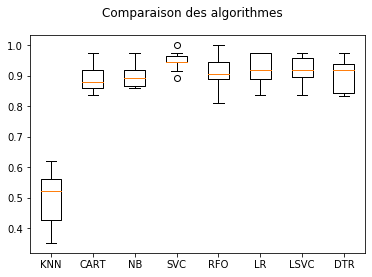

In [46]:
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)
plt.show()

## With shuffle

In [47]:
scores = []
names = []

for name, model in models:
    myKFold = KFold(n_splits = 10, shuffle = True, random_state = seed)
    startTime = time.time()
    score = cross_val_score(model, X1, y1, cv = myKFold, scoring = myScoring)
    endTime = time.time()
    scores.append(score)
    names.append(name)
    print(f'{name}\t({score.mean():.2f} | {score.std():.2f} | Time : {endTime - startTime:.2f})\n')

KNN	(0.50 | 0.06 | Time : 0.74)

CART	(0.91 | 0.05 | Time : 0.52)

NB	(0.90 | 0.06 | Time : 0.30)

SVC	(0.95 | 0.04 | Time : 2.49)

RFO	(0.93 | 0.05 | Time : 0.53)

LR	(0.93 | 0.02 | Time : 0.98)

LSVC	(0.93 | 0.03 | Time : 13.76)

DTR	(0.90 | 0.05 | Time : 0.80)



## Displaying results of the different classifiers

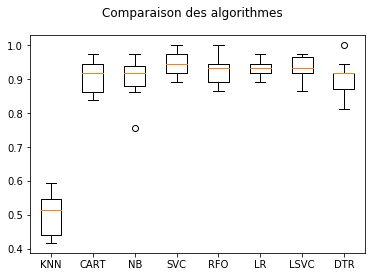

In [48]:
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)
plt.show()

## Apply GridSearchCV to RandomForestClassifier

In [49]:
gridParam = {'n_estimators': [4, 6, 9], 
             'max_features': ['log2', 'sqrt','auto'], 
             'criterion': ['entropy', 'gini'], 
             'max_depth': [2, 3, 5, 10], 
             'min_samples_split': [2, 3, 5], 
             'min_samples_leaf': [1, 5, 8]
            }

myScoring = 'accuracy'

clfGridSearchCV = GridSearchCV(estimator = RandomForestClassifier(), param_grid = gridParam, scoring = myScoring, cv = 5, n_jobs = -1, iid = True, return_train_score = True)

startTime = time.time()
clfGridSearchCV.fit(X_train1, y_train1)
endTime = time.time()

print(f'temps : {endTime - startTime:.2f}')
print(f'meilleur score : {clfGridSearchCV.best_score_:.2f}')
print(f'meilleurs paramètres :\n{clfGridSearchCV.best_params_}')
print(f'meilleur estimateur :\n{clfGridSearchCV.best_estimator_}')

# tf1
# {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 6}
# {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 6}
# {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 9}
# {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}

#tf2
# {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}

temps : 40.48
meilleur score : 0.75
meilleurs paramètres :
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 6}
meilleur estimateur :
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=6,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


## Apply GridSearchCV to DecisionTreeClassifier

In [50]:
gridParam = {'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
             'criterion' : ['gini', 'entropy'], 
             'min_samples_leaf' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
            }

myScoring = 'accuracy'

clfGridSearchCV = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = gridParam, scoring = myScoring, cv = 10, n_jobs = -1, iid = True, return_train_score = True)

startTime = time.time()
clfGridSearchCV.fit(X_train1, y_train1)
endTime = time.time()

print(f'temps : {endTime - startTime:.2f}')
print(f'meilleur score : {clfGridSearchCV.best_score_:.2f}')
print(f'meilleurs paramètres :\n{clfGridSearchCV.best_params_}')
print(f'meilleur estimateur :\n{clfGridSearchCV.best_estimator_}')

#tf1
# {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1}
# {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6}
# {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 5}
# {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1}

#tf2
# {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 4}

temps : 9.73
meilleur score : 0.66
meilleurs paramètres :
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1}
meilleur estimateur :
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


## Apply GridSearchCV to SVC

In [51]:
gridParam = {'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
             'gamma' : ['scale', 0.0001, 0.001, 0.01, 0.1, 1], 
             'kernel' : ['linear', 'poly', 'rbf']
            }

myScoring = 'accuracy'

clfGridSearchCV = GridSearchCV(estimator = SVC(), param_grid = gridParam, scoring = myScoring, cv = 5, n_jobs = 1, iid = True, return_train_score = True)

startTime = time.time()
clfGridSearchCV.fit(X_train1, y_train1)
endTime = time.time()

print(f'temps : {endTime - startTime:.2f}')
print(f'meilleur score : {clfGridSearchCV.best_score_:.2f}')
print(f'meilleurs paramètres :\n{clfGridSearchCV.best_params_}')
print(f'meilleur estimateur :\n{clfGridSearchCV.best_estimator_}')

#tf2
# {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

temps : 36.70
meilleur score : 0.95
meilleurs paramètres :
{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
meilleur estimateur :
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


## Apply GridSearchCV to KNeighborsClassifier

In [52]:
gridParam = {'n_neighbors': list(range(1,15)), 
              'metric': ['minkowski', 'euclidean', 'manhattan']
             }

myScoring = 'accuracy'
                        
clfGridSearchCV = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = gridParam, scoring = myScoring, cv = 5, n_jobs = -1, iid = True, return_train_score = True)

startTime = time.time()
clfGridSearchCV.fit(X_train1, y_train1)
endTime = time.time()

print(f'temps : {endTime - startTime:.2f}')
print(f'meilleur score : {clfGridSearchCV.best_score_:.2f}')
print(f'meilleurs paramètres :\n{clfGridSearchCV.best_params_}')
print(f'meilleur estimateur :\n{clfGridSearchCV.best_estimator_}')

temps : 4.77
meilleur score : 0.53
meilleurs paramètres :
{'metric': 'manhattan', 'n_neighbors': 2}
meilleur estimateur :
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')


## Do a gridsearch taking the previous parameters

In [53]:
classifiers = {
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'SVC': SVC(),
    'KNeighborsClassifier': KNeighborsClassifier()
}

params = {
    'RandomForestClassifier' : [
        {'n_estimators' : [9, 6]}, 
        {'max_features' : ['auto', 'sqrt', 'log2']}, 
        {'criterion' : ['entropy', 'gini']}, 
        {'max_depth' : [10]}, 
        {'min_samples_split' : [2, 5]}, 
        {'min_samples_leaf' : [1, 5]}
    ], 
    'DecisionTreeClassifier' : [
        {'max_depth' : [9, 8]}, 
        {'criterion' : ['gini', 'entropy']}, 
        {'min_samples_leaf' : [1, 2, 3]}
    ],
    'SVC' : [
        {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, 
        {'gamma': ['scale', 0.0001, 0.001, 0.01, 0.1, 1]}, 
        {'kernel': ['linear', 'poly', 'rbf']}
    ],
    'KNeighborsClassifier' : [
        {'metric': ['minkowski', 'manhattan']}, 
        {'n_neighbors': [1, 2]}
    ]
}

In [54]:
class Result:
    def __init__(self, name, score, parameters, duration):
        self.name = name
        self.score = score
        self.parameters = parameters
        self.duration = duration
    def __repr__(self):
        return repr((self.name, self.score, self.parameters, self.duration))

results = []
myScoring = 'accuracy'

for key, value in classifiers.items():
    clfGridSearchCV = GridSearchCV(estimator = value, param_grid = params[key], scoring = myScoring, cv = 10, n_jobs = 1, iid = True)
    startTime = time.time()
    clfGridSearchCV.fit(X_train1, y_train1)
    endTime = time.time()
    result = Result(key, clfGridSearchCV.best_score_, clfGridSearchCV.best_estimator_, endTime - startTime)
    results.append(result)

results = sorted(results, key = lambda result: result.score, reverse = True)

print(f'')
print(f'Le meilleur resultat est celui du classifieur {results[0].name} :\n\tScore : {results[0].score:.2f}\n\tDuration : {results[0].duration:.2f}\n\tParameters :\n\t\t{results[0].parameters}')

print(f'\nTous les résultats :\n')
for result in results:
    print(f'\t{result.name} classifier :\n\tScore : {result.score:.2f}\n\tDuration : {result.duration:.2f}\n\tParameters :\n\t\t{result.parameters}\n')


Le meilleur resultat est celui du classifieur SVC :
	Score : 0.95
	Duration : 6.18
	Parameters :
		SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Tous les résultats :

	SVC classifier :
	Score : 0.95
	Duration : 6.18
	Parameters :
		SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

	RandomForestClassifier classifier :
	Score : 0.83
	Duration : 3.74
	Parameters :
		RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_

## Save the best learned model

In [55]:
pickle.dump(results[0].parameters, open('modeles/best.sav', 'wb'))

## Create pipeline

In [56]:
#pipeline = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components = 2)), ('clf', DecisionTreeClassifier(random_state = 42))])
#pipeline = Pipeline([('vect', MinMaxScaler()), ('clf', SVC(gamma = 'scale'))])

## Reload the best model to test it with y_test

In [57]:
clf_loaded = pickle.load(open('modeles/best.sav', 'rb'))

print(f'Modèle chargé :\n{clf_loaded}\n')

result = clf_loaded.predict(X_test1)

cpt_mal_classes(y_test1, result)

print(f'Accuracy : {accuracy_score(result, y_test1):.2f}\n')
print(f'Matrice de confusion :\n{confusion_matrix(y_test1, result)}\n')
print(f'Classification report :\n{classification_report(y_test1, result)}')

Modèle chargé :
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Taille des données 258 mal classés 29

Accuracy : 0.89

Matrice de confusion :
[[129   2]
 [ 27 100]]

Classification report :
              precision    recall  f1-score   support

         0.0       0.83      0.98      0.90       131
         1.0       0.98      0.79      0.87       127

    accuracy                           0.89       258
   macro avg       0.90      0.89      0.89       258
weighted avg       0.90      0.89      0.89       258

